# Regression with Multiple Features

TO DO
- Nothing for the moment.

**ACKNOWLEDGEMENT**

**The dataset used in this notebook is from Andrew Ng's course on Machine Learning on Coursera.**

In [39]:
# Share functions used in multiple notebooks
%run Shared-Functions.ipynb

In [40]:
# Import our usual libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

## The Business Problem: Predicting Housing Prices

What's the market value of a house? One way to determine the market value is to collect up the prices of houses based on a few characteristics such as size in square feet and number of bedrooms. Then apply machine learning to "learn" what the price should be based on this data.

The data we have is a well know machine learning dataset of housing prices in Portland, Oregon. Let's refresh our memories of what this dataset looks like.

## Load the Data

In [41]:
import os
# OS-independent way to navigate the file system
# Data directory is one directory up in relation to directory of this notebook
data_dir_root = os.path.normpath(os.getcwd() + os.sep + os.pardir)
# Where the file is
file_url = data_dir_root + os.sep + "Data" + os.sep + "portland-house-prices.txt"
# Load the data into a dataframe
data2 = pd.read_csv(file_url, header=None, names=['Size', 'Bedrooms', 'Price'])

In [42]:
# The number of (rows, columns) in the dataset
data2.shape

(47, 3)

We have information about 47 homes in this dataset. Each house is described by two characteristics or "features". The 3rd column is the output column -- Price.

In [43]:
# The first few rows of the dataset
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [44]:
# Descriptive statistics of the dataset
data2.describe()

,Size,Bedrooms,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


In [45]:
# Smallest and largest square footage in the data set
data2.Size.min(), data2.Size.max()

(852, 4478)

## Step 1: Visualize the Data

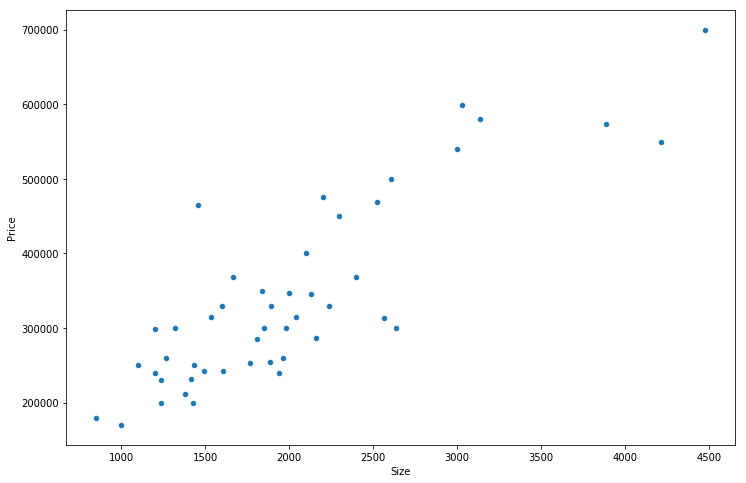

In [46]:
# Scatter plot of just the size and price
data2.plot.scatter(x='Size', y='Price', figsize=(12,8));

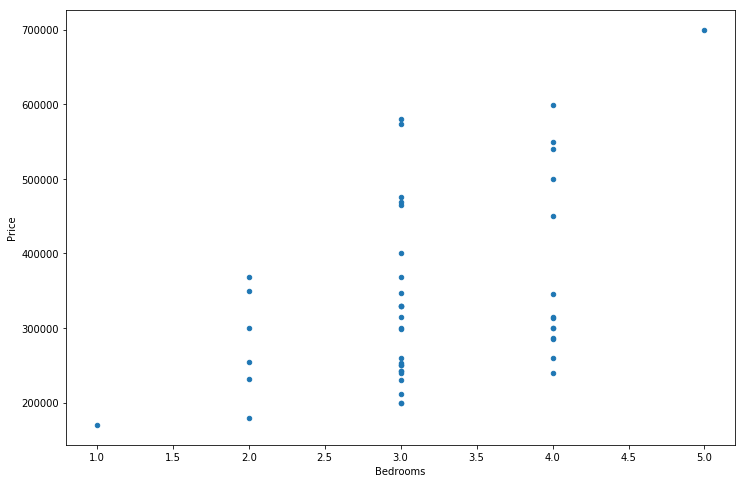

In [47]:
# Scatter plot of just the number of bedrooms and price
data2.plot.scatter(x='Bedrooms', y='Price', figsize=(12,8));

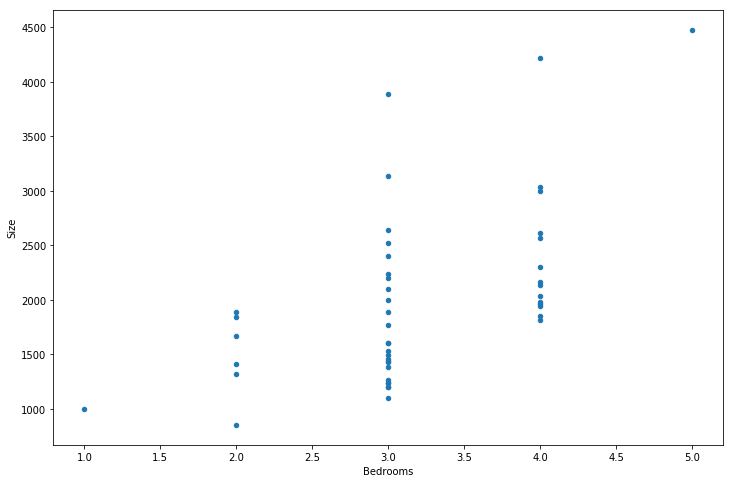

In [48]:
# Scatter plot of bedrooms and size (the 2 features)
data2.plot.scatter(x='Bedrooms', y='Size', figsize=(12,8));

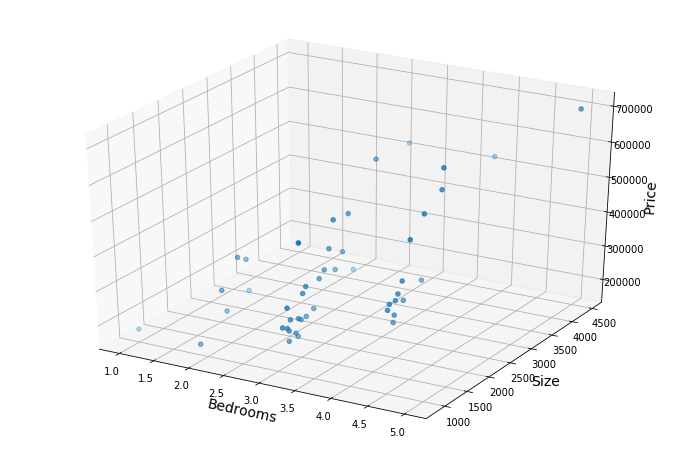

In [49]:
# From https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
# 3D scatter plot of size, bedrooms and price
from mpl_toolkits.mplot3d import Axes3D
threeD = plt.figure(figsize=(12,8)).gca(projection='3d')
threeD.scatter(data2['Bedrooms'], data2['Size'], data2['Price'])
threeD.set_xlabel('Bedrooms', fontsize=14)
threeD.set_ylabel('Size', fontsize=14)
threeD.set_zlabel('Price', fontsize=14)
plt.show()

### Rescale/Normalize the Data
Notice that the size of a house in square feet is about 1,000 times the number of bedrooms it has. Similarly, the price of a house is about 100 times the size of the house. This is quite common in many datasets, but when it happens, the iterative method of gradient descent (which we'll use again) becomes inefficient. This is simply a matter of making the computations efficient. To do so, we'll do something called *feature normalization*.

In [50]:
# Normalize the scales in the dataset
# NOTE: the output doesn't have to be rescaled but we've done that 
# here anyway
# If you know statistics: What we're doing is rewriting each value 
#  in terms of standard deviation units
data2Norm = (data2 - data2.mean()) / data2.std()
data2Norm.head()

# In Orange use the Preprocessor widget

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


In [51]:
# Let's keep track of the mean and standard deviation of the house sizes, 
#  number of bedrooms, and prices in the dataset.
# We'll need these values when we make predictions

# We can get them easily for size, bedrooms and price by using data2.mean()[0], ..., [2]
data2.mean()[0], data2.mean()[1], data2.mean()[2], data2.std()[0], data2.std()[1], data2.std()[2]

(2000.6808510638298,
 3.1702127659574466,
 340412.6595744681,
 794.70235353388966,
 0.76098188678009993,
 125039.89958640098)

## Step 2: Define the Task You Want to Accomplish

Task = Given the size of a house in square feet and the number of bedrooms it contains, predict the price of the house.

House prices are continuous quantities and so our method of prediction is going to be linear regression.

Because we have more than one feature, we'll use linear regression with multiple features.

### Step 2a: Identify the Inputs
In this case we have 2 inputs -- the size and number of bedrooms of the house. 

In [52]:
# Number of columns in the dataset
cols = data2Norm.shape[1]
# Inputs are our first two columns
X = data2Norm.iloc[:, 0:cols-1]
# Add an initial column of 1s to X to keep the notation simple
# X.insert(0,'x0',1)

In [53]:
# First few rows of features (remember it's scaled)
X.head()

,Size,Bedrooms
0,0.130010,-0.223675
1,-0.504190,-0.223675
2,0.502476,-0.223675
3,-0.735723,-1.537767
4,1.257476,1.090417


### Step 2b: Identify the Output
The output is the house price. Let's set it up as a variable y.

In [54]:
# The output -- the price of a house
# Don't need to normalize the output
#y = data2['Price']
y = data2.iloc[:, cols-1:cols]
# First few house prices in the dataset
y.head()

,Price
0,399900
1,329900
2,369000
3,232000
4,539900


## Step 3: Define the Model

### Step 3a: Define the Features

In this case our features are exactly the same as our inputs. We have 2 features: the size of a house in square feet and the number of bedrooms a house has. These are the features encoded in the variables $x_{1}$ and $x_{2}$.

Later we'll see models where the features and the inputs are not one and the same. In these cases the features are constructed by combining inputs in various ways.

### Step 3b: Transform the Inputs Into an Output

We're going to stick to a simple model -- exactly the same one as before but now with an additional feature.

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$$

The scheme for transforming inputs to an output has not changed -- it has more than 1 variable, hence the $x_{2}$ along with the $x_{1}$. 

$x_{0}$ is still always 1.

### Step 3c: Clarify the Parameters of the Model

$w_{0}$, $w_{1}$, and $w_{2}$ are the *parameters* of the model. These parameters can each take on an infinite number of values. In other words they are continuous variables. $w_{0}$ is called the *intercept* or *bias* value.

With this model, we know exactly how to transform an input into an output -- that is, once the values of the parameters are given.

Let's pick a value of X from the dataset, fix a specific value for $w_{0}$ and $w_{1}$, and see what we get for the value of y.

Specifically, let
$\begin{bmatrix}
w_{0} \\
w_{1} \\
w_{2}
\end{bmatrix} = 
\begin{bmatrix}
-10 \\
1 \\
0
\end{bmatrix}$

This means $w_{0}$ is -10, $w_{1}$ is 1, and $w_{2}$ is 0.

## Step 4: Define the Penalty for Getting it Wrong

Our cost function is exactly the same as it was before for the single variable case. 

The only difference from what we had before is the $w_{2}$ and $x_{2}$ are now added because we have 2 features rather than just one. We'll always have the same number of $w$ and $x$ values if you count the feature $x_{0}$ that we "manufacture" and set to always be equal to 1.

We're going to take $\hat{y}$ -- the predicted price -- for every row of the dataset as below:

$$\hat{y}^{(1)} = w_{0} * x_{0}^{(1)}\ +\ w_{1} * x_{1}^{(1)} +\ w_{2} * x_{2}^{(1)}$$
$$\vdots$$
$$\hat{y}^{(m)} = w_{0} * x_{0}^{(m)}\ +\ w_{1} * x_{1}^{(m)} +\ w_{2} * x_{2}^{(m)}$$

Then we'll apply the squared penalty function to the actual minus the predicted value for every row and sum these values over all the rows of the dataset.

$$ cost = (\hat{y}^{(1)} - y^{(1)})^{2} + (\hat{y}^{(2)} - y^{(2)})^{2} + \dots + (\hat{y}^{(m)} - y^{(m)})^{2} $$

In [55]:
# Compute the cost for a given set of W values over the entire dataset
# Get X and y in to matrix form
penalty(X, y, W_init, squaredPenalty)

65591714973.132927

We don't know yet if this is high or low -- we'll have to try out a whole bunch of $W$ values. Or better yet, we can use pick an iterative method and implement it.

## Step 5: Find the Parameter Values that Minimize the Penalty

Once again, the method that will "learn" the optimal values for $W$ is gradient descent. Let's use it to find the minimum cost and the values of $W$ that result in that minimum cost.

In [56]:
# Set hyper-parameters
num_iters = 2000 # number of iterations
learning_rate = 0.001 # the learning rate

### Learning Rate - The Intuition

<img src="../Images/gradient-descent-intuition.png" alt="Under- and Overshoot in Learning Size" style="width: 600px;"/>

In [57]:
# Run gradient descent and capture the progression of cost values and the ultimate optimal W values
%time W_opt, final_penalty, running_w, running_penalty = gradientDescent(X, y, W_init, num_iters, learning_rate)
# Get the optimal W values and the last few W values and cost values
W_opt, final_penalty, running_w[-5:], running_penalty[-5:]

CPU times: user 552 ms, sys: 4.22 ms, total: 557 ms
Wall time: 561 ms


(matrix([[ 294388.75819571],
         [  83415.89835571],
         [  15661.36853777]]),
 10336137845193718.0,
 [(matrix([[ 294204.20142909]]),
   matrix([[ 83358.16076765]]),
   matrix([[ 15689.07208456]])),
  (matrix([[ 294250.40988724]]),
   matrix([[ 83372.61067538]]),
   matrix([[ 15682.14789626]])),
  (matrix([[ 294296.57213692]]),
   matrix([[ 83387.05023547]]),
   matrix([[ 15675.22257117]])),
  (matrix([[ 294342.68822436]]),
   matrix([[ 83401.47945867]]),
   matrix([[ 15668.29611609]])),
  (matrix([[ 294388.75819571]]),
   matrix([[ 83415.89835571]]),
   matrix([[ 15661.36853777]]))],
 array([  1.04192003e+16,   1.03983723e+16,   1.03775860e+16,
          1.03568412e+16,   1.03361378e+16]))

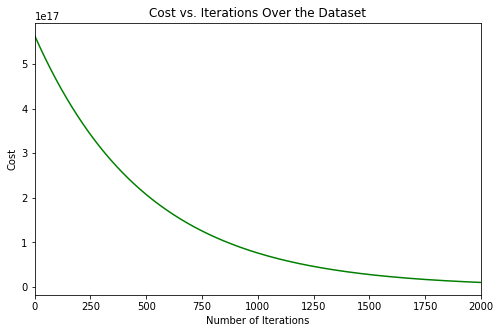

In [58]:
# How the cost changes as the number of iterations increase
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.arange(num_iters), running_penalty, 'g')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Cost')
plt.xlim(0,num_iters)
ax.set_title('Cost vs. Iterations Over the Dataset');

In [59]:
# Run gradient descent for a few different values of the learning rate
learning_rates = [0.0001, 0.003, 0.005, 0.01, 0.03, 0.1]
gdResults = [gradientDescent(X, y, W_init, num_iters, learning_rates[i]) for i in range(len(learning_rates))]
#gdResults

In [60]:
# For each learning rate, get the progression of costs
#  for each iteration
penalty_list = [gdResults[i][3] for i in range(len(gdResults))]
penalty_list[0]

array([  5.65351470e+17,   5.65238405e+17,   5.65125363e+17, ...,
         3.79186298e+17,   3.79110465e+17,   3.79034646e+17])

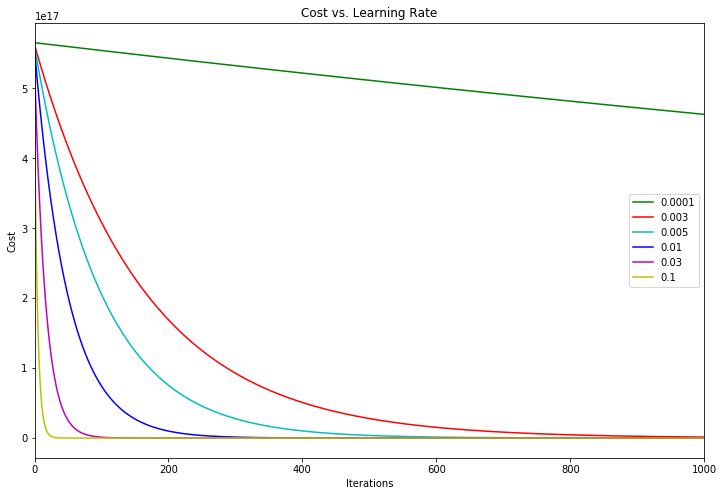

In [61]:
# How the cost of the transformation varies with the learning rate
plot_color_list = ['g', 'r', 'c', 'b', 'm', 'y']
fig, ax = plt.subplots(figsize=(12,8))
[ax.plot(np.arange(num_iters), penalty_list[i], plot_color_list[i], label=learning_rates[i]) for i in range(len(learning_rates))]
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.legend()
plt.xlim(0,1000)
ax.set_title('Cost vs. Learning Rate');

## Step 6: Use the Model and Optimal Parameter Values to Make Predictions

It looks like a learning rate greater than 0.003 is good enough to get our iterative gradient descent to plunge down to arrive at the lowest cost value and stay there. 

Let's make some predictions...What is our prediction for a house that is 5,000 square feet in size with 4 bedrooms? Let's plug these in to our model and use the optimal $W$ values we've calculated above.

In [68]:
# Change size and num_bedrooms to make distinct predictions
size = 3000
num_bedrooms = 3

# Remember we've run the model using rescaled house sizes and number of bedrooms
# So we should scale the inputs down and then scale the prediction up when we're done
size_scaled = (size - data2.mean()[0])/data2.std()[0]
beds_scaled = (num_bedrooms - data2.mean()[1])/data2.std()[1]

# This is our model -- we're just using it here to make a calculation
pred_price = (W_opt[0] * 1) + (W_opt[1] * size_scaled) + (W_opt[2] * beds_scaled)

# Format and print the result
print("Predicted Price: ", '${:20,.0f}'.format(math.ceil(pred_price)))
print("Optimal Parameter Values: {}".format(W_opt))

Predicted Price:  $           3,229,834
Optimal Parameter Values: [[ 294388.75819571]
 [  83415.89835571]
 [  15661.36853777]]


Let's see how the prediction is sensitive to the number of iterations and the learning rate.

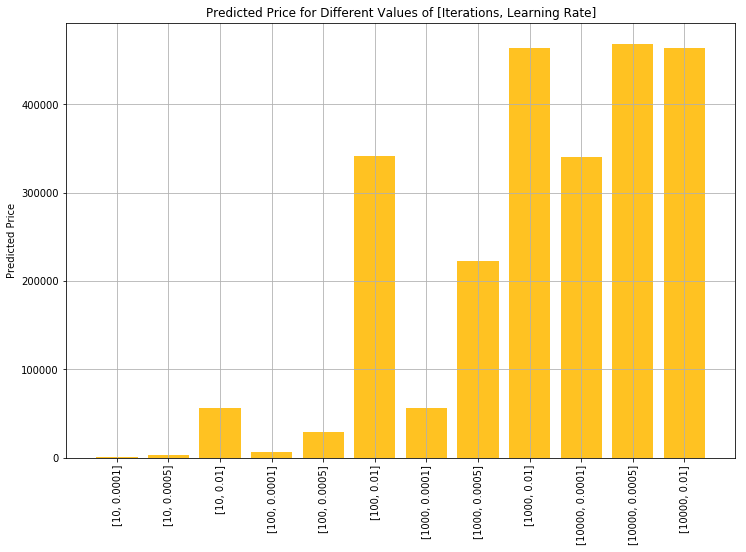

In [63]:
# Try different values
n_iters = [10, 100, 1000, 10000]
l_rate = [0.0001, 0.0005, 0.01]

# Keep these the same
sq_ft = 3000
rooms = 5

# get it into the right format to plug into the gradient descent function
combos_list = []
for i in range(len(n_iters)):
    for j in range(len(l_rate)):
        combos_list.append([n_iters[i], l_rate[j]])

# Run gradient descent on all the different combinations
gdResults = [gradientDescent(X, y, \
                             W_init, combos_list[i][0], combos_list[i][1]) for i in range(len(combos_list))]

# Here are the optimal parameter values for these settings
W_values = [gdResults[i][0] for i in range(len(gdResults))]

# Price for each set of optimal values
# Remember we've run the model using rescaled house sizes and number of bedrooms
# So we should scale the inputs down and then scale the prediction up when we're done
size_scaled = (sq_ft - data2.mean()[0])/data2.std()[0]
beds_scaled = (rooms - data2.mean()[1])/data2.std()[1]

# This is our model -- we're just using it here to make a calculation
pred_prices = [(W_values[i][0] * 1) + (W_values[i][1] * size_scaled) + (W_values[i][2] * beds_scaled) \
              for i in range(len(W_values))]

# Convert pred_prices from a list of matrices into a simple list
# This makes it suitable for plotting
prices_out = np.array(pred_prices).reshape(1,-1).squeeze()

#print(combos_list)

# Format and print the result
#[print("Predicted Price: ", '${:6,.0f}'.format(math.ceil(pred_price))) for pred_price in pred_prices]

# Plot the results
fig,ax = plt.subplots(figsize=(12,8))
# Define the number of the bars
x_pos = list(range(len(combos_list)))
# Set the bar labels
bar_labels = combos_list
ax.bar(x_pos, prices_out, width=0.8, color='#FFC222')
# set axes labels and title
plt.ylabel('Predicted Price')
plt.xticks(x_pos, bar_labels, rotation=90)
plt.title('Predicted Price for Different Values of [Iterations, Learning Rate]')
# add a grid
plt.grid()
plt.show()

## Step 7: Measure the Performance of the Model

We're going to delay this step until later on in the course.

## Summary

Regression with more than one feature is just as straightforward to implement as regression with one feature. Having more features makes it harder to visualize the penalty surface (three or more parameters means we'd have to produce 4-dimensional plots -- which are harder to visualize). Also, having more features makes it a more intense optimization problem; but thankfully, computers are especially good at this sort of thing.

In fact, it would be quite difficult to write efficient versions of gradient descent for large optimization problems. Again, thankfully, this is a vast areas of research in applied mathematics (numerical computational techniques) and computer science (algorithm design). We will soon be tapping into this work and use highly efficient numerical computation techniques and algorithms to crunch through our machine learning problems.

The concepts of machine learning and the 7 steps -- what it is how machines/software programs are able to do it -- remain the same throughout. To recap, we learned about the following:
- dataset inputs, features, and outputs
- the model for transforming features into outputs and its parameters
- the penalty for straying from the correct output
- the algorithm for finding the optimal values of the parmeters (the algorithm for "learning" the optimal parameters)
- the "hyperparameters" of the learning algorithm -- learning rate and number of iterations over the entire dataset
- making predictions based on the learned optimal values of the model parameters